https://www.gdal.org/gdal_retile.html



## Import

In [7]:
import pandas as pd
import geopandas # http://geopandas.org/reference.html
import matplotlib.pyplot as plt

import imageio

import glob
import numpy as np

import os
import shutil     # Kopiering av filer
from osgeo import ogr, gdal    # GDAL

# Python kode som delar opp bildet.
import gdal_retile

In [2]:
# Check that unpacked files are there. Unpack them?
!ls ../Raw_data

20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.dat
20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.dat.aux.xml
20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.hdr
20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.zip
20180705-biri_02_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.dat
20180705-biri_02_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.hdr
20180705-biri_02_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.zip


In [3]:
# Global variables:
imagestripes_names = glob.glob('../Raw_data/*.dat') # Lists every imagestripe
imagestripes_out_dir = '../Merged_image_stripes/'



name_tiles= glob.glob('../Merged_image_stripes/*.tif') # Lists every imagefile
#ame_shapefile = "shapefile/utsnit.shp"
name_csv = 'tile_envelope_coordinates.csv'
in_directory = '../Sorted_tiles'
out_directory = '../Sorted_tiles/mis_tiles'

# Size of output tile
tile_with = '50'
tile_heigth = '50'

## Merge bands

In [3]:
imagestripes_names

['../Raw_data/20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.dat',
 '../Raw_data/20180705-biri_02_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.dat']

In [46]:
# Run merge function for each set of VNIR and SWNIR stripes
for i, k in enumerate(imagestripes_names[::2]):
    print(f'Prossesing stripe {i+1} of {len(name_imagefiles)}')
    print(f'Merging {name_imagestripes[1]} and {name_imagestripes[0]})

    
    # The highes resolution image as fist input. In this case VNIR before Swnir.
    cmd = 'gdal_merge.py -o '+ imagestripes_out_dir +'stripe_merged_'+ str(2+i) +'.tif -separate -v -ot Float32 -of GTiff '+ name_imagestripes[1] + name_imagestripes[0]
    
    os.system(cmd)


gdal_merge.py -o ../Merged_image_stripes/stripe_merged_2.tif -separate -v -ot Float32 -of GTiff ../Raw_data/20180705-biri_02_VNIR_1800_SN00827_raw_rad_bsq_float32_geo.hdr../Raw_data/20180705-biri_02_SWIR_384me_SN3126_raw_rad_bsq_float32_geo.dat.aux.xml
0


## Make tiles

In [21]:
# Run retilefunction for each image
for i, image_name in enumerate(name_imagefiles):
    print(f'Prossesing image {i+1} of {len(name_tiles)}')
    
    cmd = 'gdal_retile.py -ps ' + tile_with +' '+ tile_heigth + ' -overlap 0 -levels 1 -r near -ot Float32 -csv '+ str(i) + name_csv + ' -csvDelim "," -targetDir '+'\''+in_directory+'\''+ ' ' +'\''+image_name+'\''
    #print(cmd)
    os.system(cmd)

Prossesing image 1 of 1


### Delete empyt tiles or tiles with non spesified shape 

In [8]:
list_tiles = glob.glob('../Sorted_tiles/*.tif')
tiles_to_be_removed = []

In [9]:
def get_input(path):
    
    img = imageio.imread(path)
    
    return(img)

In [10]:
# Checks tiles and delete the irregular ones.
for tile_path in list_tiles:
    image = get_input(tile_path)
    
    if not image.any(): # Checks if image is only zeroes, no data.
        tiles_to_be_removed.append(os.path.basename(tile_path))
        os.remove(tile_path) 
        
    elif image.shape != (int(tile_with), int(tile_heigth), 474): # Checks if image is correctly shaped
        tiles_to_be_removed.append(os.path.basename(tile_path))
        os.remove(tile_path)

/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functiona

In [12]:
print(f'{len(tiles_to_be_removed)} tiles was deleted.')

649 tiles was deleted


## Find categories
Label 99 means that the tile contains no MIS-label.

In [13]:
MIS_code_key = pd.read_excel(io='../Prosjekt_Honne_data_Landbruksdirektoratet/Koder Mis-nin i shape pilot 2.0.xlsx', sheet_name='LM.kode')
MIS_code_key

,Kode,Navn
0,1,Stående død ved
1,2,Liggende død ved
2,3,Rikbarkstrær
3,4,Trær med hengelav
4,5,Eldre lauvsuksesjoner
5,6,Gamle trær
6,7,Hule lauvtrær
7,8,Brannflater
8,9,Rik bakkevegetasjon
9,10,Bergvegger


In [14]:
# Read mis-polygons
mis_geometry_mjosen = geopandas.read_file('../Prosjekt_Honne_data_Landbruksdirektoratet/Leveranse_MiS_201017_Mjosen/MiS_NiN_Biri_Mjosen_2017.shp')

mis_geometry_mjosen.head()

,OBJECTID,AREAL,REG_DATO_F,KGRAD,VERDI,NATURTYPE,KGRAD_BEGR,SKOGBESKRI,FORVALTNIN,FKODE,...,UT_EKSP,KI_VANNP,LIVSM1,LIVSM2,area,sum_lauv,sum_gamle,sum_LDV,sum_SDV,geometry
0,0,8,2017-09-01,0,None,0,None,Ensjiktet produksjonsskog av gran og noe bjørk...,None,1,...,b,A2,2,1,8159,0,0,19,16,"POLYGON ((585266.8620801514 6754440.302978287,..."
1,0,2,2017-09-01,0,None,0,None,Gamle furutrr I blanding med gran og noe lauv.,None,1,...,d,A2,6,0,2251,0,7,0,0,"POLYGON ((585548.5608584847 6754543.789799314,..."
2,0,3,2017-09-12,0,None,0,None,Bekkeklöft med noe liggende død ved og hengestry.,None,1,...,a,A2,12,2,3235,0,0,15,0,"POLYGON ((586009.7207604215 6754258.584550213,..."
3,0,3,2017-09-12,0,None,0,None,Liggende og noe stående død ved.,None,1,...,a,A2,2,0,2871,0,0,10,0,"POLYGON ((586245.598938267 6754403.08832045, 5..."
4,0,9,2017-09-13,0,None,0,None,Også noe stående død ved.,None,0,...,b,A2,2,0,9474,0,0,14,0,"POLYGON ((587132.3176386385 6754551.368164727,..."


<Figure size 432x288 with 0 Axes>

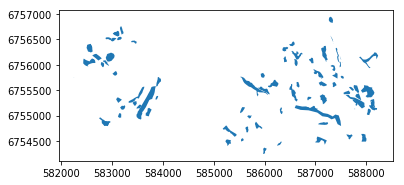

In [15]:
# Plot mis-polygons
plt.figure()
mis_geometry_mjosen.plot()
plt.show()

### Test polygon

In [16]:
mis_geometry_test = geopandas.read_file('../Qgis/test_polygon/testpolygon_rett_epsg.shp')
mis_geometry_test.head()

,id,LIVSM1,LIVSM2,geometry
0,1,1,0,"POLYGON ((587035.6726263626 6757593.473657084,..."
1,2,1,0,"POLYGON ((587080.3170862239 6757522.567750248,..."
2,3,2,0,"POLYGON ((586998.0312190288 6757590.847512389,..."
3,4,2,3,"POLYGON ((587065.4355996035 6757496.306303267,..."
4,5,5,4,"POLYGON ((587234.3842418236 6757473.546382557,..."


<Figure size 432x288 with 0 Axes>

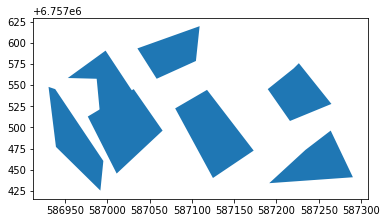

In [17]:
# Plot mis-polygons
plt.figure()
mis_geometry_test.plot()
plt.show()

## Sort tiles

In [45]:
# Merge all csv files to one big
all_files = glob.glob(os.path.join(in_directory, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f, names = ["Tile_name", "X_ul", "X_lr", "Y_ul", "Y_lr"]) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

In [46]:
concatenated_df.count()

Tile_name    1197
X_ul         1197
X_lr         1197
Y_ul         1197
Y_lr         1197
dtype: int64

In [47]:
concatenated_df.head()

,Tile_name,X_ul,X_lr,Y_ul,Y_lr
0,all_bands_merged_01_01.tif,586706.55,586721.55,6757675.55,6757690.55
1,all_bands_merged_01_02.tif,586721.55,586736.55,6757675.55,6757690.55
2,all_bands_merged_01_03.tif,586736.55,586751.55,6757675.55,6757690.55
3,all_bands_merged_01_04.tif,586751.55,586766.55,6757675.55,6757690.55
4,all_bands_merged_01_05.tif,586766.55,586781.55,6757675.55,6757690.55


In [48]:
# Remove tiles found to be irregular or not wanted
concatenated_df = concatenated_df[~concatenated_df['Tile_name'].isin(tiles_to_be_removed)]
concatenated_df.reset_index(drop=True, inplace=True)
concatenated_df.head()

,Tile_name,X_ul,X_lr,Y_ul,Y_lr
0,all_bands_merged_01_31.tif,587156.55,587171.55,6757675.55,6757690.55
1,all_bands_merged_01_32.tif,587171.55,587186.55,6757675.55,6757690.55
2,all_bands_merged_01_33.tif,587186.55,587201.55,6757675.55,6757690.55
3,all_bands_merged_01_34.tif,587201.55,587216.55,6757675.55,6757690.55
4,all_bands_merged_01_35.tif,587216.55,587231.55,6757675.55,6757690.55


In [49]:
concatenated_df.count()

Tile_name    551
X_ul         551
X_lr         551
Y_ul         551
Y_lr         551
dtype: int64

In [50]:
# Create a geometry of every tile (bounding box)
# https://gis.stackexchange.com/questions/285336/convert-polygon-bounding-box-to-geodataframe
b = [geopandas.base.box(l, b, r, t) for l, b, r, t in zip(concatenated_df.X_ul, concatenated_df.Y_lr, concatenated_df.X_lr, concatenated_df.Y_ul)]

gdf = geopandas.GeoDataFrame(concatenated_df, geometry=b)

# Create dataframe to save labels
labeled_tiles = pd.DataFrame(gdf['Tile_name'])
labeled_tiles.index.name = 'ID'

# Create label collum, label 99 means no "no MIS label"
labeled_tiles["LIVSM1"] = int(99)
labeled_tiles["LIVSM2"] = int(99)

In [51]:
labeled_tiles.head()

,Tile_name,LIVSM1,LIVSM2
ID,,,
0,all_bands_merged_01_31.tif,99,99
1,all_bands_merged_01_32.tif,99,99
2,all_bands_merged_01_33.tif,99,99
3,all_bands_merged_01_34.tif,99,99
4,all_bands_merged_01_35.tif,99,99


In [47]:
# Modifisert
# Bruk informasjonen i mis_geometry.LIVSM_XXX for å tilegne klasse i sorteringa. Lagre dette i csv-fil eller inn i 
# concatenated_df. Då kan ein lese navn på flisa og i same slengen også leggje til miskoden inn i generatoren. Altså
# både x (imageread(filnamn)) og y (klassekoden).
# Check if a tile is inside a mis-polygon. Sorts tiles. 
for mis_geom_num, mis_geom_row in mis_geometry_mjosen.iterrows():
    print(f'Checking polygon {mis_geom_num + 1} of {len(mis_geometry_mjosen)}')

    # Check if tile geometries is inside a mis-polygon
    for index, row in gdf.iterrows():    
        # If tile is inside, sort it into folder
        if mis_geom_row['geometry'].contains(row['geometry']):
            #shutil.move(in_directory + '/' + row['Tile_name'], out_directory + '/' + row['Tile_name']) 
            labeled_tiles.loc[labeled_tiles.index[index], 'LIVSM1'] = (int(mis_geom_row['LIVSM1']))
            labeled_tiles.loc[labeled_tiles.index[index], 'LIVSM2'] = (int(mis_geom_row['LIVSM2']))

            #print(f'Label {gdf["mis_label"][index]} given tile {row["Tile_name"]}')
            print('Label LIVSM1 {0} LIVSM2 {1} given tile {2}'.format(labeled_tiles["LIVSM1"][index], labeled_tiles["LIVSM2"][index], row["Tile_name"]))

Checking polygon 1 of 83
Checking polygon 2 of 83
Checking polygon 3 of 83
Checking polygon 4 of 83
Checking polygon 5 of 83
Checking polygon 6 of 83
Checking polygon 7 of 83
Checking polygon 8 of 83
Checking polygon 9 of 83
Checking polygon 10 of 83
Checking polygon 11 of 83
Checking polygon 12 of 83
Checking polygon 13 of 83
Checking polygon 14 of 83
Checking polygon 15 of 83
Checking polygon 16 of 83
Checking polygon 17 of 83
Checking polygon 18 of 83
Checking polygon 19 of 83
Checking polygon 20 of 83
Checking polygon 21 of 83
Checking polygon 22 of 83
Checking polygon 23 of 83
Checking polygon 24 of 83
Checking polygon 25 of 83
Checking polygon 26 of 83
Checking polygon 27 of 83
Checking polygon 28 of 83
Checking polygon 29 of 83
Checking polygon 30 of 83
Checking polygon 31 of 83
Checking polygon 32 of 83
Checking polygon 33 of 83
Checking polygon 34 of 83
Checking polygon 35 of 83
Checking polygon 36 of 83
Checking polygon 37 of 83
Checking polygon 38 of 83
Checking polygon 39 o

### Test polygon

In [52]:
# Modifisert
# Bruk informasjonen i mis_geometry.LIVSM_XXX for å tilegne klasse i sorteringa. Lagre dette i csv-fil eller inn i 
# concatenated_df. Då kan ein lese navn på flisa og i same slengen også leggje til miskoden inn i generatoren. Altså
# både x (imageread(filnamn)) og y (klassekoden).
# Check if a tile is inside a mis-polygon. Sorts tiles. 
for mis_geom_num, mis_geom_row in mis_geometry_test.iterrows():
    print(f'Checking polygon {mis_geom_num + 1} of {len(mis_geometry_test)}')
    
    # Check if tile geometries is inside a mis-polygon
    for index, row in gdf.iterrows():    
        # If tile is inside, sort it into folder
        if mis_geom_row['geometry'].contains(row['geometry']):
            #shutil.move(in_directory + '/' + row['Tile_name'], out_directory + '/' + row['Tile_name']) 
            labeled_tiles.loc[labeled_tiles.index[index], 'LIVSM1'] = (int(mis_geom_row['LIVSM1']))
            labeled_tiles.loc[labeled_tiles.index[index], 'LIVSM2'] = (int(mis_geom_row['LIVSM2']))

            #print(f'Label {gdf["mis_label"][index]} given tile {row["Tile_name"]}')
            print('Label LIVSM1 {0} LIVSM2 {1} given tile {2}'.format(labeled_tiles["LIVSM1"][index], labeled_tiles["LIVSM2"][index], row["Tile_name"]))

Checking polygon 1 of 7
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_07_25.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_07_26.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_08_24.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_08_25.tif
Checking polygon 2 of 7
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_12_27.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_12_28.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_13_27.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_13_28.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_13_29.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_14_28.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_14_29.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_15_28.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_15_29.tif
Label LIVSM1 1 LIVSM2 0 given tile all_bands_merged_15_30.tif
Checking polygon 3 of 7
Label LIVSM1 2 LIVSM2 0 given tile all_bands_merged_09_20.ti

MultiLabelBinarizer is used to make a multilabel binary label. This labelvector is used by the model.

In [53]:
from sklearn.preprocessing import MultiLabelBinarizer

mergedlabels = [list(pair) for pair in zip(labeled_tiles['LIVSM1'].values, labeled_tiles['LIVSM2'].values)]

# If the tile only have one label, only one label is given. 0 is ignored == no label.
mlb = MultiLabelBinarizer(classes=[1,2,3,4,5,6,7,8,9,10,11,12,99])
binarized_labels = mlb.fit_transform(mergedlabels)

/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/sklearn/preprocessing/label.py:935: UserWarning: unknown class(es) [0] will be ignored
  .format(sorted(unknown, key=str)))


In [54]:
labels_as_colums = pd.DataFrame(binarized_labels, columns=mlb.classes)
labels_as_colums.head()

,1,2,3,4,5,6,7,8,9,10,11,12,99
0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1


In [55]:
# Convert binarized_labels to dataframe
bin_labels_dict = {'index': list(range(len(binarized_labels))), 
        'mult_bin_labels': binarized_labels.tolist()}
binarized_labels_dataframe = pd.DataFrame(bin_labels_dict, columns = ['index', 'mult_bin_labels'])

# view the dataset
binarized_labels_dataframe.head()

,index,mult_bin_labels
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


In [56]:
labeled_tiles_bin = pd.concat([labeled_tiles, binarized_labels_dataframe['mult_bin_labels'], labels_as_colums], axis=1)
labeled_tiles_bin.tail()

,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
ID,,,,,,,,,,,,,,,,,
546,all_bands_merged_19_18.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
547,all_bands_merged_19_19.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
548,all_bands_merged_20_01.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
549,all_bands_merged_20_02.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
550,all_bands_merged_20_03.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1


In [57]:
# Save csv to file
labeled_tiles_bin.to_csv('../Qgis/labeled_tiles.csv')

labeled_tiles_bin.head()

,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
ID,,,,,,,,,,,,,,,,,
0,all_bands_merged_01_31.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
1,all_bands_merged_01_32.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
2,all_bands_merged_01_33.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
3,all_bands_merged_01_34.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
4,all_bands_merged_01_35.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1


In [68]:
labeled_tiles_bin[5].value_counts()

0    540
1     11
Name: 5, dtype: int64

## Read images

In [201]:
import imageio
im = imageio.imread('../Sorted_tiles/1.jpg')

import random
import scipy.ndimage
no = random.randrange(-180,180,30)
flipped_patch = scipy.ndimage.interpolation.rotate(im, 45,axes=(1, 0), reshape=False, output=None, order=3, mode='reflect', cval=0.0, prefilter=False)


In [196]:
flipped_patch.shape

(183, 275, 3)

In [197]:
flipped_patch[0][0]

array([ 90,  99, 116], dtype=uint8)

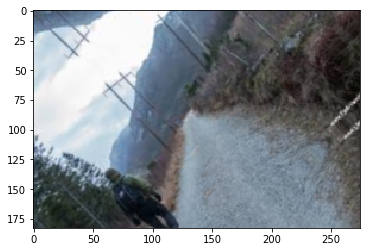

In [200]:
plt.imshow(flipped_patch)

In [116]:
im.shape

(183, 275, 3)

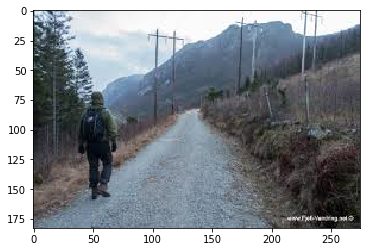

In [112]:
import matplotlib.pyplot as plt
plt.imshow(im)

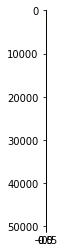

In [213]:
from sklearn.decomposition import PCA
pca = PCA(.95)
X = im.reshape(-1, 3)
pca.fit(X)
pca.explained_variance_ratio_


img_transformed = pca.transform(X)

plt.imshow(img_transformed)

In [13]:
from PIL import ImageEnhance
from PIL import Image
import numpy as np

im = Image.open('../Sorted_tiles/1.jpg')
im2 = imageio.imread('../Sorted_tiles/1.jpg')


In [16]:
print(np.array(im).shape)
print(im2.shape)
print(im-im2)

(183, 275, 3)
(183, 275, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
